# 画像生成

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# データセット作成
train_dataset = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

In [3]:
# データローダー作成
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # エンコーダー
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)

        # デコーダー
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        # 潜在空間の平均
        mu = self.fc31(h)
        # 潜在空間の分散
        log_var = self.fc32(h)
        return mu, log_var

    def sampling(self, mu, log_var):
        # 潜在空間の標準偏差
        std = torch.exp(0.5 * log_var)
        # ランダムな値を生成
        epsilon = torch.randn_like(std)
        # 潜在空間の点をサンプリング
        z = epsilon.mul(std).add_(mu)
        return z

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()


In [5]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [6]:
optimizer = optim.Adam(vae.parameters())

def loss_function(reconstructed_x, x, mu, log_var):
    binary_cross_entropy = F.binary_cross_entropy(reconstructed_x,
                                                  x.view(-1, 784),
                                                  reduction="sum")

    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return binary_cross_entropy + kl_divergence

In [12]:
def train(epoch):
    vae.train()
    train_loss = 0
    log_x = []
    log_y = []
    for batch_index, (data, _) in enumerate(train_loader):
        data = data.cuda() if torch.cuda.is_available() else data
        optimizer.zero_grad()
        reconstructed, mu, log_var = vae(data)
        loss = loss_function(reconstructed, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_index % 100 == 0:
            number_of_data = batch_index * len(data)
            total_number_of_data = len(train_loader.dataset) * (epoch - 1) + number_of_data
            average_loss = loss.item() / len(data)
            print(f"エポック: {epoch}, バッチ: {batch_index}, 損失: {average_loss}")
            log_x.append(total_number_of_data)
            log_y.append(average_loss)

    print(f"====> エポック: {epoch}, 平均損失: {train_loss / len(train_loader.dataset)}")
    return log_x, log_y
    

In [13]:
def test():
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda() if torch.cuda.is_available() else data
            reconstructed, mu, log_var = vae(data)
            test_loss += loss_function(reconstructed, data, mu, log_var).item()
    
    test_loss /= len(test_loader.dataset)
    print(f"====> テストセット上の損失: {test_loss}")
    return test_loss

エポック: 1, バッチ: 0, 損失: 542.436328125
エポック: 1, バッチ: 100, 損失: 183.25009765625
エポック: 1, バッチ: 200, 損失: 166.0358984375
エポック: 1, バッチ: 300, 損失: 168.82099609375
エポック: 1, バッチ: 400, 損失: 169.3083203125
エポック: 1, バッチ: 500, 損失: 159.499609375
====> エポック: 1, 平均損失: 178.8287208984375
====> テストセット上の損失: 162.13487333984375
エポック: 2, バッチ: 0, 損失: 164.45505859375
エポック: 2, バッチ: 100, 損失: 165.59484375
エポック: 2, バッチ: 200, 損失: 160.246953125
エポック: 2, バッチ: 300, 損失: 157.383603515625
エポック: 2, バッチ: 400, 損失: 153.585595703125
エポック: 2, バッチ: 500, 損失: 155.3715234375
====> エポック: 2, 平均損失: 157.48927483723958
====> テストセット上の損失: 154.8045453125
エポック: 3, バッチ: 0, 損失: 157.75220703125
エポック: 3, バッチ: 100, 損失: 153.282890625
エポック: 3, バッチ: 200, 損失: 160.398349609375
エポック: 3, バッチ: 300, 損失: 150.597353515625
エポック: 3, バッチ: 400, 損失: 153.55822265625
エポック: 3, バッチ: 500, 損失: 148.240322265625
====> エポック: 3, 平均損失: 152.67566544596355
====> テストセット上の損失: 150.92289697265625
エポック: 4, バッチ: 0, 損失: 141.084140625
エポック: 4, バッチ: 100, 損失: 149.002412109375
エポック: 4, バッチ

Text(0, 0.5, 'Binary Cross Entropy + KL Divergence')

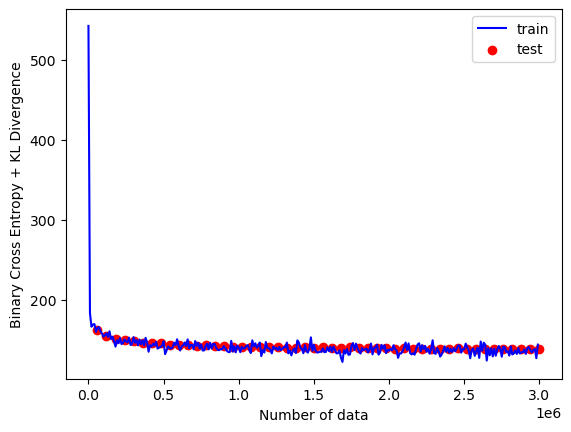

In [15]:
train_log_x = []
train_log_y = []
test_log_x = []
test_log_y = []
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)
optimizer = optim.Adam(vae.parameters())
if torch.cuda.is_available():
    vae.cuda()
for epoch in range(1, 51):
    log_x, log_y = train(epoch)
    test_loss = test()
    train_log_x += log_x
    train_log_y += log_y
    test_log_x.append(len(train_loader.dataset) * epoch)
    test_log_y.append(test_loss)

import matplotlib.pyplot as plt
plt.plot(train_log_x, train_log_y, label="train", color="blue")
plt.scatter(test_log_x, test_log_y, label="test", color="red")
plt.legend(["train", "test"])
plt.xlabel("Number of data")
plt.ylabel("Binary Cross Entropy + KL Divergence")


In [16]:
# モデルの保存
torch.save(vae.state_dict(), "vae.pth")

In [ ]:
# モデルの読み込み
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=2)
vae.cuda()
vae.load_state_dict(torch.load("vae.pth"))
vae.eval()

/tmp/ipykernel_57000/3067830051.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae.pth"))


VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

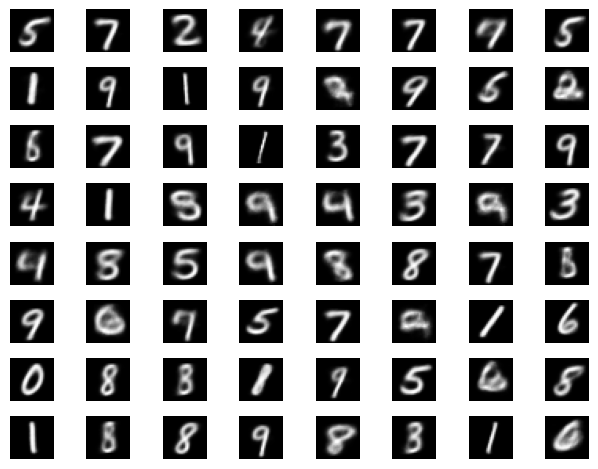

In [28]:
# 64枚の画像を生成
z = torch.randn(64, 2).cuda()
sample = vae.decoder(z).cuda()
sample = sample.view(64, 1, 28, 28)
fig, axes = plt.subplots(8, 8)
for i in range(64):
    ax = axes[i // 8, i % 8]
    image = sample[i].cpu().detach().numpy().squeeze()
    ax.imshow(image, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()